# Classification of Parkinssons disease patients using EEG signals #
*Ekaterina Lavrova* 
## Pipeline overview ##
* Import packages
* Import data
* Filter data 
* Prepare ICA and data for artifact removal
* Apply ICA
* Plot ICA components to identify artifacts 
* Apply ICA to remove artifacts
* Defining feature functions
* Apply feature extraction
* Build classification model
* Validate classifier
* Evaluate classifier
* Code improvement documentation

## Import Packages ##
 * What the imported libraries are used for:
      * **os:** Used to modify datapaths when importing data, can also be used when changing or setting directories. 
      * **numpy (np):** In this programme np is used for various mathematical operations. And to store data in arrays as this is needed for the knn classifier, where euclidean distances are calculated. 
      * **pandas (pd):** Used to modify and create dataframes to store data. 
      * **MNE:** Mne is a library used for electrophysiological signal processing. E.g. to set montage (indicate position of electrodes) and for epoching which is needed for feature calculations. A submodule of Mne called preprocessing is also used. From the submodule the ICA class is imported. It is used to remove signal artifacts . 
      * **welch from scipy.signal:**
Welch from scipy.signal is used to compute bandpower.
      * **Sklearn (scikit learn)**:
This library is used in machine learning. In this project it is used to  evaluate and validate the k-NN model. E.g. StandardScaler is used to scale the data before validating the k-NN model. LeaveOneOut is used to  validate of the k-NN model and the accuracy_score, recall_score, confusion_matrix classes are used to evaluate the model providing statistical information about the performance of the machine learning model. 

In [42]:
#import packages 
import os
import numpy as np
import pandas as pd 
import mne 
from mne.preprocessing import ICA
from scipy.signal import welch 
from sklearn.preprocessing import StandardScaler  
from sklearn.model_selection import LeaveOneOut 
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix


 ## Import Data ##
 * **Code explanation:**
The filepath to the input files is entered by the user, and an empty list for the import is initiated. The loop iterates over the the directory. By using mne, it  imports the bdf files.  All files are saved in raw_list (empty list initiated at the top of the cell).

    Error handling is added through specifying the file type that is requested by the programme (.bdf). If a file does not end with bdf a statement is printed saying the file is not bdf then the loop skips the rest of the loop and starts reading in the next file. If there is a problem when loading the file after the exclusion of the wrong fileformats the loop will print an exception indicating that the file could not be loaded, which file it concearns and why. 
 * **Input:**
This programme uses 31 datafiles from the San diego dataset including 16 healthy- and 15 parkinsons patient (samples).

 * **Output:**
If verbose = false is not used, an output for every file read will be generated. It will then indicate what file type is identified, how long time it takes to read the file and that the data is converted into a raw.info object which contains the data and the meta data of the file.

* **Design choices:**
The *preload* command is used to load the data into the RAM so that we can edit the file, e.g. filter or remove artifacts. Verbose is also used here and will be used in cells further down. This tells python to not print output. Some of these processing steps print massive amounts of output since have 31 files. And this output is not interesting for the project at hand.

    I choose raw as the variable name for every file imported as this is the standard name used when working with mne. It indicates that the data is raw (non-proccessed). It is also a class in mne and various functions can be applied directly to it, making it easy to use.

  Lasly, I choose to do this in a loop as this is a very short script and therefore does not need to be cleaned up in a function. 

In [3]:
file_path = input("Enter filepath to the bdf files here (no quotation marks):") #Ask user for filepath

Enter filepath to the bdf files here (no quotation marks): C:\Users\katja\Programing_project\EEG-signal_processing_and_classification_of_parkinsson_disease-\input_data


In [5]:
#import data
raw_list = []

for file in os.listdir(file_path):
    if not file.endswith(".bdf"): 
        print (f"Skipping {file}, it is not a bdf file")
        continue
    try:
        raw = mne.io.read_raw_bdf(os.path.join(file_path, file), preload = True,verbose = False) 
        raw_list.append(raw)

    except Exception as e : 
        print(f"Could not load {file}:{e}")

## Filter Data ##

* **Code explanation:**
The file with index 4 from raw_list is plotted. The plot shows 30 seconds of the signal and is scaled so that the signals can bee seen easily as separate electrode signals. This is done by multiplying all voltages by 200 * 10^-6 using the scaling dictionary from MNE. Further bandpass filtering  and notch filtering is done by directly applying methods to the raw objects in the raw_list. Then re-referencing is done. And same file is plotted again after filtering to be able to compare the before and after and see if filtering has been succesfull.

* **Input:** raw_list containing the data and metadata of all imported files (raw and raw.info).

*  **Output:** Two plots of file 4 showing the EEG signals of each electrode channel. First plot shows unfiltered signals and the second one shows signals that are filtered and re-referenced. It is clear that  the filtering has been successful ass a lot of noice is removed. This noise can be caused by bad electrode contact, powerline noise, muscle artifacts or interfering electromagnetic fields. 

- **Design Choices:**
  * Why it is done in a loop?  
    As this process is not reused throughout the program I did not find it necessary to create a function for it. It is also easier to debug the loop and change the thresholds. Similarly, to save memory I apply the filtering directly to a raw object while in a function i would need to create a return variable which would double the memory I need for the data.  
    
  * Filtering threshold:  
    The bandpass filter keeps all signals between 1 and 40 Hz which are normally the actual brain signals. Signals that are below 1 can indicate an error in measurement, sweating or slow muscle movement. Signals higher than 40 Hz are normally artifacts such as muscle movements, powerline noise, or electromagnetic interference. 40 Hz is a common clinical threshold as it removes unwanted signals but keeps all relevant brain information.

  * Notch filtering  
    The bandpass filter does not cut of the signals at 1 and 40 but rather keeps these specific signals untouched and attenuates the higher frequencies so that they gradually decrease. Therefore, we also require notch filtering. Notch filtering specifically removes 60 Hz frequency as this is the standard US Powerline noise (the data used was meassured and collected in the US).
  
  * Re-referencing   
    Referencing is done to remove noise that could have been caused during measurement. The electrodes measure signals in reference to one reference-electrodes on the head to get comparable signals.  Since this reference electrode can pick up artifacts or noisy signals it contaminates the rest of the electrodes as it subtracts that artifact from the other signals. Therefore, all electrodes are re-referenced by averaging all of the electrodes. This average becomes the new reference. 


Using matplotlib as 2D backend.


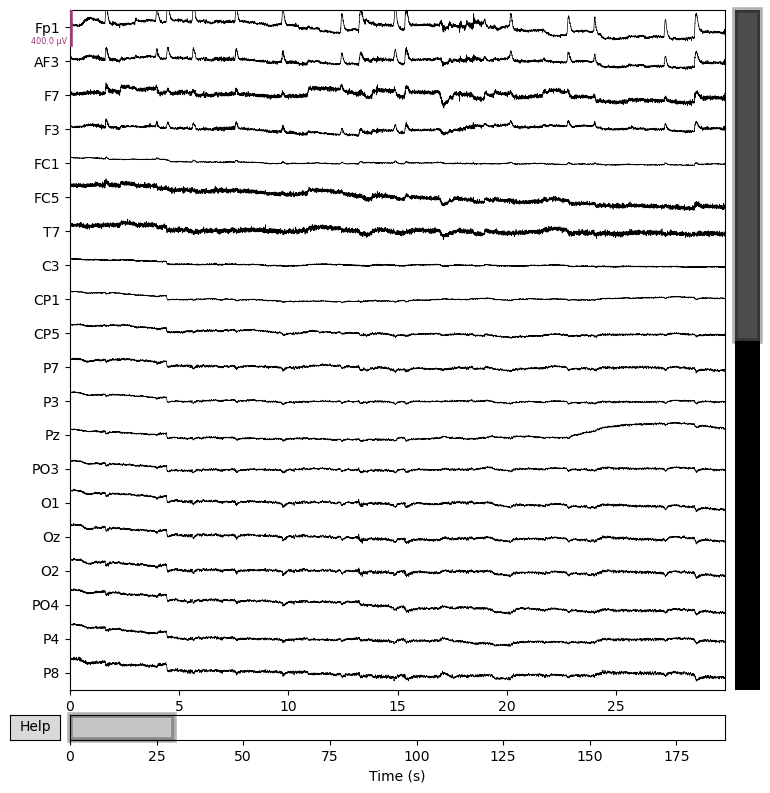

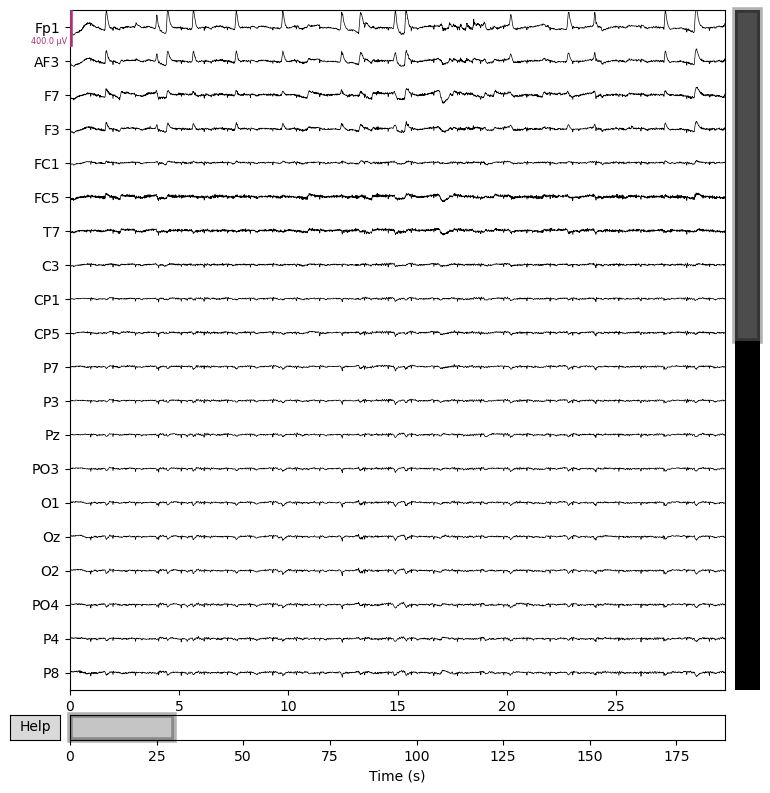

In [8]:
#Filtering 
raw_test = raw_list[4]
raw_test.plot(start = 0, duration = 30,scalings = dict(eeg=200e-6)); # Scaled plot of file with index 4 (before filtering)

for raw in raw_list: 
    raw.filter(1.0,40.0, verbose = False) # Bandpass filtering 
    raw.notch_filter(60.0, verbose = False) # Notch filtering ( 60 Hz US standards, change to 50 Hz in Europe)
    raw.set_eeg_reference('average', verbose = False) # Rereferencing using the average method

raw_test.plot(start = 0, duration = 30,scalings = dict(eeg=200e-6)); # Plot after filtering

## Prepare ICA and data for artifact removal ##
* **Code explanation:**
Set Montage, configure ICA and divide the signals into components. Further, EXG channels are removed. ICA is configured using the fastica method and I choose to split it into 15 components. This is a random process therefore random_state was set. Then the components are appended to ica_list initiated at the beggining of the cell.

* **Input:** raw_list containing raw obejcts each containing filtered EEG data (Output of previous cell).

* **Output:** Verbose is set to false to remove non-relevant output. There is still some output, which are the warnings indicating that for each file in raw_list, the EXG channels are changed to NA which is exactly what we want to do. However, the program treats it as something unexpected therefore giving a warning.

- **Design Choices:**
  * **Why is this code implemented?**
    To prepare tools and data for artifact removal. As there is no information about EOG or ECG channels in the datset, ICA can be used to identify components including the artifacts. In above graphs the large amplitudes in the top channels most probably represent ocular artifacts and the continuous small spikes seen after filtering in all channels are most probably ECG artifacts. Lastly, it is important to include only relevant channels measuring brain activity therefore EXG channels were removed. Moreover, for ICA to work it needs to know the positions of the electrode which is here derived by setting montage using the 10 20 system as this is the standard electrode positioning.
 
    * **Why it is done in a loop?**  
    As this process is not reused throughout the program I did not find a reason to create a function for it. It is also easier to debug the loop and change the thresholds.

  * **ICA configuration choices:**
      * *Fastica method* 
    Fastica is one of the best methods for artifact separation. It is also very fast and easy to configure.
      * *15 components*
    Normaly, number of components chosen should explain 90 to 95 percent of variance in the dataset which means that the same number of components as channels should be chosen. But since this dataset is very small it is prone to overfitting therefore a lower number as 15 (around half of the number of channels) is more suitable.

      * *Why ICA?*
    Other methods such as manual filtering is time consuming and it is easy to miss artifacts. Regression models are only good if we have EOG and ECG channels present, and other models use very sharp cutoffs meaning that meaningful brain data is excluded. Therefore ICA is the best choice here.
       

In [11]:
ica_list = [] # Empty list for ICA components 

for raw in raw_list:
    montage = mne.channels.make_standard_montage('standard_1020') # Give channels positions according to the 10 20 system 

    # Mark EXG channels as miscellaneous 
    raw.set_channel_types({
        'EXG1':'misc', 'EXG2':'misc', 'EXG3':'misc', 'EXG4':'misc',
        'EXG5':'misc', 'EXG6':'misc', 'EXG7':'misc', 'EXG8':'misc'
    })
    raw.set_montage(montage)

# Configure and fit ICA to the data
for raw in raw_list:
    ica = ICA(n_components=15, method='fastica', random_state=42, verbose = False)
    ica.fit(raw, verbose = False )
    ica_list.append(ica)

C:\Users\katja\AppData\Local\Temp\ipykernel_37940\2008910406.py:7: RuntimeWarning: The unit for channel(s) EXG1, EXG2, EXG3, EXG4, EXG5, EXG6, EXG7, EXG8 has changed from V to NA.
  raw.set_channel_types({
C:\Users\katja\AppData\Local\Temp\ipykernel_37940\2008910406.py:7: RuntimeWarning: The unit for channel(s) EXG1, EXG2, EXG3, EXG4, EXG5, EXG6, EXG7, EXG8 has changed from V to NA.
  raw.set_channel_types({
C:\Users\katja\AppData\Local\Temp\ipykernel_37940\2008910406.py:7: RuntimeWarning: The unit for channel(s) EXG1, EXG2, EXG3, EXG4, EXG5, EXG6, EXG7, EXG8 has changed from V to NA.
  raw.set_channel_types({
C:\Users\katja\AppData\Local\Temp\ipykernel_37940\2008910406.py:7: RuntimeWarning: The unit for channel(s) EXG1, EXG2, EXG3, EXG4, EXG5, EXG6, EXG7, EXG8 has changed from V to NA.
  raw.set_channel_types({
C:\Users\katja\AppData\Local\Temp\ipykernel_37940\2008910406.py:7: RuntimeWarning: The unit for channel(s) EXG1, EXG2, EXG3, EXG4, EXG5, EXG6, EXG7, EXG8 has changed from V to 

## Plot ICA components to identify artifacts ##

* **Code explanation:** Components of file with index 4 is ploted. In this small datasets the artifacts are present in the same components for all files (can be investigated by changing which index is plotted).It takes a lot of time to plot all components for all files therefore it is easier to plot for one file at a time if wanted.
    
* **Input:**
  One component file (components for one raw file) from the ica_list. And one raw file containing filtered data. 

* **Output:**
Topographies with colors indicating signal density covered by each component.

    Overlay graphs indicating signals before and after removal of chosen components. The red line is before component removal and the black one is after component removal. There are 3 plots shown for each component excluded. The raw plot shows all the channels in file 4 stacked on top of eachother. Plot 2 shows the same signal but globaly scaled therefore looks much cleaner. And the third shows the mean signal over all the channnels in the file. 

- **Design choices:**
  * **Why this code is implemented?**
    This code uses the fitted ICA from previous cell and visualizes the components as topographies that can be manully analyzed to identify componenets containing artifacts and exclude them. Then overlay plots are made, where the red line is the signal before filtering and black is after filtering away artifacts. This is plotted to seee if removal of a specific artifact makes a difference.
  * **Why exclude component 1 and 0?**
    Component 0 has strong  occular artifacts with strong positive voltage in the frontal lobe and no other strong brain activity. Component 1 is a definet indication on ECG artifacts. Heartbeat is seen in all channels since the hearts electrical activity is strong and spreads over the whole body. The raw and ica file can be changes to any index and it is seen  that the components that need to be exclude are the same across different files. Therefore we can do a harsh cutoff here for all files. The artifact removal effect is confirmed in overlay graphs. ECG artifacts normally have a depolariwation signal large dip which then comes up above zero and then dips again in a pattern. Occular artifacts are large amplitudes that go above zero. And both are removed in the overlay plots. 


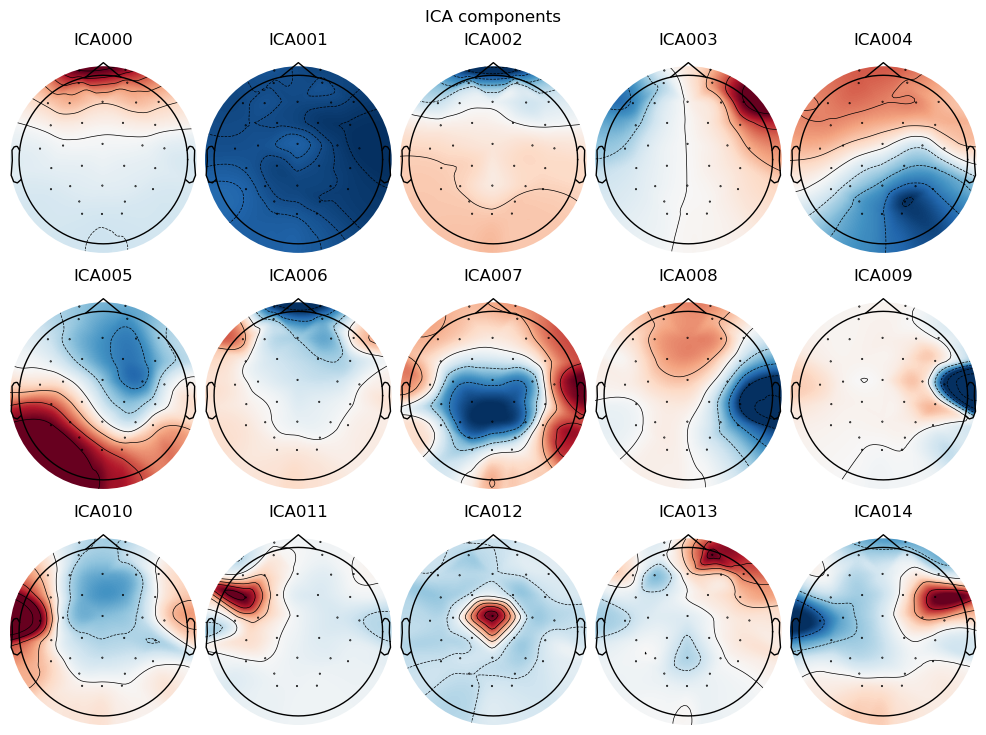

Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 32 PCA components


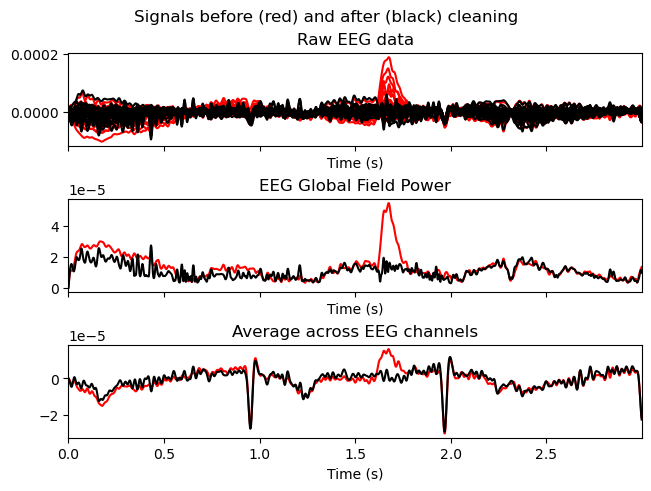

Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 32 PCA components


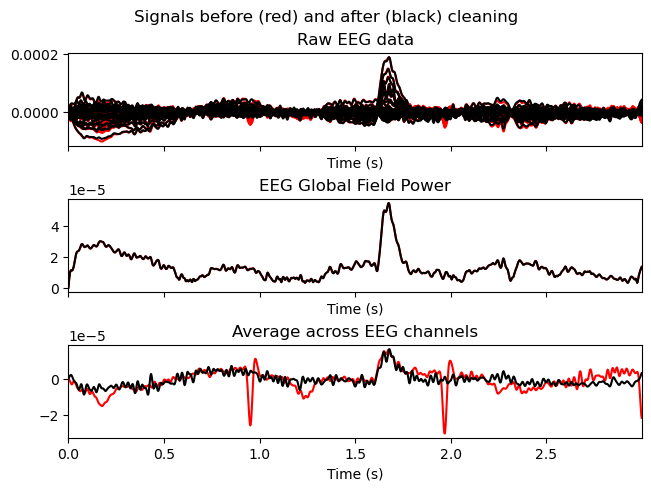

In [15]:
# Creates variable  that only include one file
raw_test = raw_list[4]
ica_test = ica_list[4]

# Plot components of one file 
ica_test.plot_components()

# Plot overlay of raw signal with specific ICA components excluded for one file 
ica_test.plot_overlay(raw_test, exclude=[0]);  # exclude component 0 in file idx 4 (ocular artifact)
ica_test.plot_overlay(raw_test, exclude=[1]);  # exclude component 1 in file idx 4 (ECG artifact)

## Apply ICA to remove artifacts ## 
* **Code explanation:**   Initiating an empty list to save all the processed data. Looping through the raw_list and the ica list defined in previous cells and exclude component 0 and 1  from the raw_list.  A copy of the raw_list is created  with applied ica and saved in raw_clean. Then appended to processed raw list ready fro feature extraction.

* **Input:**   Ica_list and raw_list  indicated in previous cells.

* **Output:**   No output  is shown but produces a processed_raw file containing filtered data files without artifacts.

* **Design choices:**   A copy of each raw object is created (where artifacts are removed). ICA is not directly applied to the raw object. This is done to keep the original raw objects if it is needed to process the data in another way or plot it to compare data. 


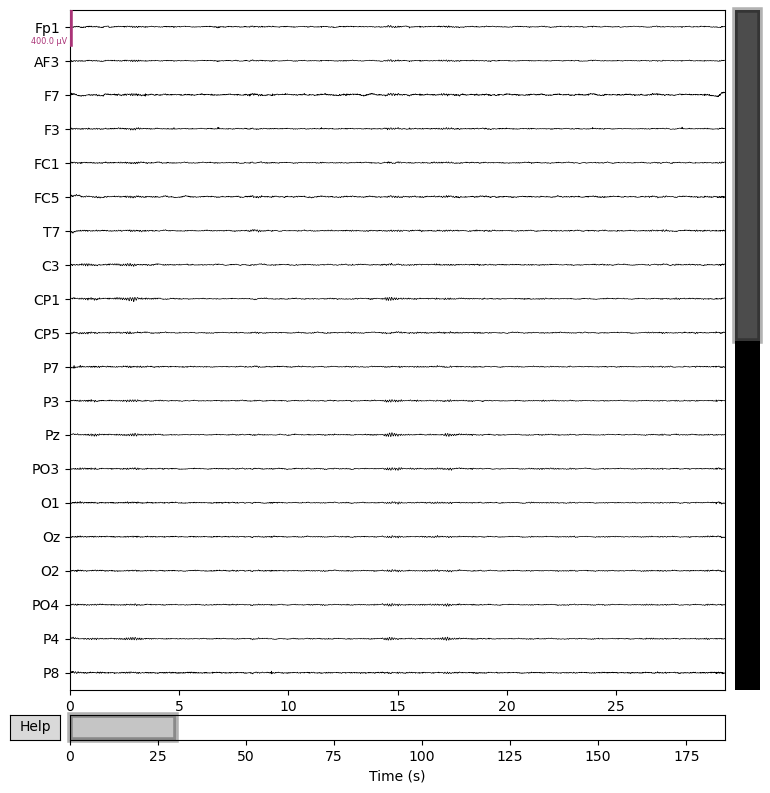

In [18]:
#Apply ICA filtering 
processed_raw = []

#Combine ICA and and the raw datafiles 
for ica, raw in zip(ica_list, raw_list):
    ica.exclude = [0,1] # exclude components 

    raw_clean = ica.apply(raw.copy(), verbose = False) # Create copies of each raw file with ica applied 
    processed_raw.append(raw_clean) # add raw_copies to list

# Plot one file from the processed list to compare with unfiltered plot
raw = processed_raw [1]
raw.plot (start = 0, duration = 30, scalings=dict(eeg=200e-6));

## Defining Feature Functions ##
* **Code explanaiton:**     
  Created 2 functions for Shannon entropy and bandpowers. The Shannon entropy function takes each segment and groups its voltages/ amplitudes in 50 bins returning the densities of each bin( how many values that fall within each bin) and edges which is the lowest and highest voltages in each bin. Bin widths are then calculated by substracting the bin edges in each bin. By multiplying these we get the propability of a random voltage from that segment to fall within this specific bin creating a distribution of propabilities for each segment. This distribution is then put into the entropy calculation to get entropy. A low entropy means that the signal in the segment is predictable, distribution is centered in some bins. While high entropy means signal is unpredictable meaning distribution is even across most bins.

    Band power function takes each segment and the sample frequency of the meassurement. Then uses the welch method. This method converts the time domain with time on x axis and amplitude on y axis to frequency domain, with frequency on x axis ans power on y axis. The segment is then divided into frequency bins which each have a power. Higher power means higher occurence of that frequency. nperseg=len(signal) this argument tells the function how many datapoints to use for power calcuations. Since it is set to signal it takes the whole segment. Then we specify the frequencies of different bands. 
    Then a boolen mask for each band is created, if a frequency bin  fits in it, it is marked true otherwise false. Using the trapezoidal rule we calculate the are under the curve for all the true bins and sum them. 

* **Input and Output**  
  As these are only function definitions they do not have any input or output. What they take as input when used is defined above.

- **Design choices:**  
  * Why in functions?
This is the feature calculation that needs to be done on all datafiles and data needs to be epoched and segmented already creating a longer loop. Therefore by creating functions it is not only possible to reuse the code but also make calculations and code cleaner.

  * Feature Choice:   
    Firstly the features complement each other where shannon entropy focuses on signal variability and patterns. Band power focuses on the specific bands which all appear due to different neurological processes. The combination shows both signal complexity and energy distribution. I choose bandpower as it complements shannon entropy through representation of energy distribution. And Shannon entropy becuase it is very stable and does not need long signals or extreamly clean data to work.
 
  * Number of entropy bins:
    Shannon entropy calculates the predictability of a signal. To accurately calculate it we divide the segment in bins. 50 bins is a standard compromize when working with EEG data as it captures the varability in a good way and does not make the process to complicated or noisy. 

In [21]:

#Computing shannon entropy 
def shannon_entropy(segment, bins = 50):
    """
    Purpose:
    Calculates Shannon entropy from EEG segments

    Parameters: 
    segment: numpy.ndarray
    A channel of an epoch in an EEG datafile. 
    
    bins: int 
    Number of "Amplitude/voltage" bins the segment is divided into

    Returns: float 
    Shannon entropy of a segment. A low entropy means that the signal in the segment is predictable,
    distribution is centered in some bins while high entropy means signal is unpredictable meaning 
    distribution is even across most bins.
    """
    density, bin_edges = np.histogram(segment, bins=50, density=True)
    bin_widths = np.diff(bin_edges) # difference between bin edges
    propability = density * bin_widths # Propability calculation
    propability = propability[propability > 0] # Only keeping propabilities over 0 (otherwise log does not work)
    return -np.sum(propability * np.log2(propability))



#Computing bandpower 
def compute_bandpowers(segment, sfreq):
    """
    Purpose:
    Calculates Bandpowers from EEG segments

    Parameters: 
    segment: numpy.ndarray
    A channel of an epoch in an EEG datafile. 
    
    sfreq: int or float 
    Sampling frequency of the EEG data 

    Returns: dictionary
    Bandpower of a segment. Returns a dictionary containing all the bandpower 
    values of each segment and under which band it fits.
    """
    
    freqs, psd = welch(segment, sfreq, nperseg=len(segment))

#Defining band frequencies 
    bands = {
        'delta': (0.5, 4),
        'theta': (4, 8),
        'alpha': (8, 12),
        'beta':  (12, 30),
        'gamma': (30, 45)
    }

    bp = {}
    for band, (low, high) in bands.items(): #Looping through bands to define frequency range 
        idx = (freqs >= low) & (freqs <= high) #boolean mask indicating if the frequencies in the segment fall inside a specific frequency band 
        bp[band] = np.trapz(psd[idx], freqs[idx]) # Calculates psd for the frequencies in the specific band and segment 
    return bp

## Apply feature extraction ##
* **Code explanation:**
  A function takes the segmented data and normalizes it, excluding any segments which have a standard deviation of 0. Helperfunctions from previous cell are then applied within the feature extraction fucntion to calculate shannon entropy and bandpowers. The values are then saved in the variable features which is returned from the funciton. The main pipeline then takes the name of each file in filepath and saves it in the variable files. The loop then takes every processed file and groups it with its file name. The file name is modified to identify group and subject of the file and then saved in the variebles subject and file. Since entropy and band powers take segments for their calculation, the data is epoched using the mne library. Since Epochs is an MNE object containing meta data we want to extract only the epochs from it. In the next loop for every epoch a channel (segment) is taken and the feature extraction function is applied. If features are not removed by the sd = 0 filter, group and subject derived earlier is added to per_epoch_features. This is then added to the final_features. We create a dataframe from this to be able to apply pandas methods to it such as *group by* and *mean*. The segment features are grouped by subject and saved. To structure the dataframe in a readable way *concat* is used. And then the data is saved into a csv file. As there are only 31 samples I printed the whole dataframe below, in a larger dataset the head would be enough. 

* **Input:**
    The file path to the files (specified by user earlier in the notebook), Number of epochs, samplefrequency.
* **Output:**
    Data frame both printed and saved as a csv file including entropy values ans bandpowers for each subject in the dataset. 
- **Design Choices:**
  * I choose to put the feature extraction in a function so that it can be reused. It includes  all the main steps for the feature extraction and the main pipeline includes the data preparation and saving. As well as additioning subject and group. This function can be used on many different datasets while in the main pipeline some things, like the editig of file names is specific for this dataset.
  * I choose to average the segments due to the time constraints of the project as it takes longer time and requires a longer and more advanced code. By using averaging we also get stable data per subject instead of per segment. But while reducing noise, variability is also reduced. As a first project in EEG processing I found this model fitting as it is simple to interpret the code and the results. The epoch length was tested between 10 to 25 with increases of 5. The classification model was applied to data derived with all epoch lengths where 20s got the best statistical results. 

In [24]:
#Function for feature extraction
def feature_extraction (segment, sfreq): #Normalize data and do not include segments with voltage std of the signal is 0 
     """
     Purpose:
     Feature extraction from EEG segments using previously defined functions. 

     Parameters: 
     segment: numpy.ndarray
     A channel of an epoch in an EEG datafile. 
    
     sfreq: int or float 
     Sampling frequency of the EEG data 

     Returns: dictionary
     Returns a dictionary containing entropy and bandpower features for the segment. 
     """
     std = np.std(segment)
     if std == 0 or np.isnan(std):
         return None 
     segment = (segment - np.mean(segment))/std #Normalize (Z-score)
     entropy_values = shannon_entropy(segment) #applying shannon entropy function to segments 
     bp_values = compute_bandpowers(segment , sfreq) # applying bandpower function to segments 
     features = {"entropy" : entropy_values} # Add entropy values to features dictionary 
     features.update(bp_values) # Add bandpower values to features dictionary 
     return features #Return dictionary 

In [26]:
epoch_duration = 20
final_features = [] #Initialize empty list for final values 





# Edit file names and add group + subject 
files = [file for file in os.listdir(file_path) ] #Iterate over files in file path and save filenames in "files"
# Pair each processed file with its' filename and assign a group and subject based on the file name 
for raw_clean, file in zip(processed_raw, files):
    group = "healthy" if "sub-hc" in file else 'pd' # if filename contains "sub-hc" assign to healthy
    subject = file.split('_')[0].replace('sub-','') # Keep everything before _ in file name and remove the "sub" letters to get subject
    
    per_epoch_features =[] #Initiate empty list to keep features before averaging


    
#Prepare data through segmentation and apply feature_extraction 
    #Epoch the data 
    epochs =mne.make_fixed_length_epochs(
        raw_clean, 
        duration = epoch_duration, # epochs length  
        preload = True, # save in RAM to be able to edit files 
        verbose = False)
    extracted_epochs = epochs.get_data() #Extract epochs to data 

    
    for i in range(extracted_epochs.shape[0]): # for epoch in epochs of data 
        
        for ch in range (extracted_epochs.shape[1]): # for channels in channels of data
            segment = extracted_epochs[i, ch, :] # segment the data by extracting from one channel, from one epoch including all its timepoints 
            features = feature_extraction(segment, raw_clean.info['sfreq']) #Apply feature extraction fucntion on segmented data and sampling frequency
            
            if features: # if there is a feature in features (not remove by std = 0) continue 
                features.update({"group": group,"subject": subject}) # add group and subject to features 
                per_epoch_features.append(features) # Append features content to the second initiated list 



    
#Average and save the results
    #Create dataframe from list  
    df_epochs = pd.DataFrame(per_epoch_features)

    #Average the segmented data per subject 
    df_averaged_epochs = df_epochs.groupby(
        ["subject", "group"]).mean(numeric_only = True).reset_index() # indicate to only use numeric data for averaging 
    final_features.append(df_averaged_epochs) # Append the averaged data to firstly initiated list 





# Create final data frame and concatinate to get subject labels on y axis and feature labels on x axis 
per_subject_features = pd.concat(final_features, ignore_index = True)

per_subject_features.to_csv("EEG_features.csv", index = False) # Save data frame as CSV 
print(per_subject_features) # Investigate the data

   subject    group   entropy     delta     theta     alpha      beta  \
0     hc10  healthy  4.536463  0.333868  0.099597  0.125064  0.347768   
1     hc18  healthy  4.383992  0.330642  0.093060  0.261358  0.181752   
2      hc1  healthy  4.481215  0.392384  0.070657  0.140218  0.295277   
3     hc20  healthy  4.626748  0.398977  0.145436  0.089267  0.225110   
4     hc21  healthy  4.467400  0.373665  0.076719  0.216643  0.206619   
5     hc24  healthy  4.511418  0.313776  0.110057  0.264072  0.196505   
6     hc25  healthy  4.552981  0.362497  0.096530  0.075080  0.294505   
7     hc29  healthy  4.569924  0.269071  0.092026  0.362668  0.205454   
8      hc2  healthy  4.491755  0.382919  0.104308  0.157513  0.251809   
9     hc30  healthy  4.593980  0.448623  0.079455  0.176677  0.150150   
10    hc31  healthy  4.230137  0.369417  0.098731  0.070643  0.253736   
11    hc32  healthy  4.592886  0.363962  0.120570  0.081618  0.351236   
12    hc33  healthy  4.489899  0.344494  0.089645  

## Build classification model ##
* **Code explanation:**
  Building a k-NN model. Eucledian distances are calculated based on its standard calculation where a and b are points of each subject. Eucledian distances are then used to get predictions of the unknown subjects group. Data is divided in X-test and X-train. y-train is the group column with known groups for the subject to train the X-train dataset. And k value is the number of neighbours used to classify a point. A nympy array is created including the eucledian distance for x from the xt's in X_train. The distances are then sorted and labeled depending on xt's group (xt = x from training set). Labels are counted and the label that appears the most is added to y_pred. 
* **Input:**
  Non, since this is just function definitions.
* **Output:**
   Non, since this is just function definitions.
* **Design choices:**
  I choose to do a knn classifier since it was one of the classifiers that was specified in the article used for this project. The other classifier specified, that is normally better for a smaller dataset is SVM. However since I needed to build the model from "scratch" SVM was much more complex as it includes advanced mathematical computations and k-NN was therefore more suitable. This code was put in fuctions for its reproducibility and a cleaner code. 


In [29]:
# Calculate eucledian distances 
def eucledian_distances (a,b):
    return np.sqrt(np.sum(( a - b) ** 2 )) # Calculate eucledian distances between 2 points 

# KNN classifier
def knn_classifier ( X_train, X_test, y_train, k = 11):
    """
    Purpose:
    Classify datapoints (subjects) based on the entropy and bandpowers derived before  

    Parameters: 
    X_train: numpy.ndarray
    Training part of the dataset containing the entropy and bandpowers per subject (known group in y_train) 
    
    X_test: numpy.ndarray
    Test part of the dataset containing the entropy and bandpowers per subject (unknown group)
    
    y_train: numpy.ndarray
    Group labels for the training dataset
    
    k = 11: integer 
    Indicates how many neighbours to use in classification. 
    
    Returns: numpy ndarray
    Returns an array containing the predicted labels of the datapoints (subjects) 
    """

    y_pred = []
    for x in X_test:
        distances  = np.array([eucledian_distances(x, xt) for xt in X_train]) # Compute distances from x to all training points 
        idx = distances.argsort()[:k] #Find index of k nearest neighbour 
        labels = y_train[idx] #Label idx depending on k nearest neighbour
        counts = np.bincount(labels) #Count amount  of each label 
        y_pred.append(np.argmax(counts)) #Append the label with highest count 
    return np.array(y_pred) # Return prediction labels as numpy array

## Validate classifier ## 
* **Code explanation:**
  Two empty lists are initiated. The first list  has the true group labels of each subject. And the second list has the predicted group labels for each subject. The CSV file with features is imported and features as well as group and subject are defined in an X and y varibale. Since the k-NN classifier only takes values and no strings. Both X and y are converted to values. Then Leave one out cross validation is used to test the k-NN model. Both the X and y are split in training and testing datasets. The data is then scaled to account for that features have different units and ranges. The classifer is then applied and the predicted values are added to the y_pred list. 
* **Input:**
  CSV file with features of the data 
* **Output:**
  No Output 
* **Design choices:**
  LOOCV was choosen as classification method sicne the data set I use is very small and therefore using a k fold or a 20 80 split would not be as accurate and would give much lower statistical results. Extend is used instead of append in the last rows since when we split the dataset we get separate arrays. And by using append we add separate arrays to the list instead of adding separate elements to it. By using extend separat values are added. 

In [32]:
#Leave one out cross validation 
y_true = [] # True class
y_pred = [] # Predicted class

#Import data 
feature_df = pd.read_csv("EEG_features.csv")

#Specify features for classification 
X = feature_df[["entropy","delta","theta","alpha","beta", "gamma"]].values

#Specify group and subject 
y = feature_df["group"].map({"healthy" : 0, "pd" : 1}).values  #convert pandas series to numpy array

loo = LeaveOneOut()

for  train_idx, test_idx in loo.split(X): # For each sample split the dataset in 1 test sample and N - 1 training samples 
    X_train,X_test = X[train_idx], X[test_idx] #define index for X train and test set 
    y_train, y_test = y[train_idx], y[test_idx] #define index for y test and train set 

    scaler = StandardScaler() # Scale the data 
    X_train_scaled = scaler.fit_transform(X_train) # Scale data using sd and mean from training data 
    X_test_scaled = scaler.transform (X_test) # Scale data using sd and mean from the training data 

    y_pred_temp = knn_classifier(X_train_scaled,  X_test_scaled, y_train, k = 11) # Apply  knn_classifier

    y_true.extend (y_test) # Add true labels to list 
    y_pred.extend (y_pred_temp) # Add predicted values to list 


## Evaluate Classifier ##
* **Code explanation:**
  Calculating statistics of the classifier. recall_score is a method from the sckitlearn library calculating sensitivity and speciificity. This is multiplied by 100 to get percentage values. The confusion matrix is printed in a dataframe format to increase interpretability of results. 
* **Input:**
  The lists produced in above cell including true labels and predicted labels by the classifier. 
* **Output:**
  Accuracy, Specificity (True negative rate), Sensitivity (true positive rate) of the classification results and a confusion matrix where the top left corner and bottom right corner are correctly classified subjects. Around 60 percent indicates that the classifier is better than random guessing but large improvements can still be made to improve it.
* **Design choices:** The .2f is added in the end of the top 3 print statements to print only the first 2 decimals as it is not relevant to print out all of the deecimals. And the percent sign is added for interpretability purposes. 

In [35]:
accuracy = accuracy_score(y_true, y_pred) * 100
sensitivity  = recall_score(y_true, y_pred, pos_label = 1)* 100 
specificity  = recall_score(y_true, y_pred, pos_label = 0)* 100 

cm = confusion_matrix(y_true, y_pred)

confucion_matrix_df = pd.DataFrame(cm, index=["Actual healthy","Actual PD"], columns=["Predicted Healthy", " Predicted PD"])
    

print (f" Accuracy: {accuracy:.2f}%")
print (f" Specificity: {specificity:.2f}%")
print (f" Sensitivity: {sensitivity:.2f}%")
print (confucion_matrix_df)

 Accuracy: 61.29%
 Specificity: 62.50%
 Sensitivity: 60.00%
                Predicted Healthy   Predicted PD
Actual healthy                 10              6
Actual PD                       6              9


- **Code improvements:**
    - To improve statistics
* Larger dataset size to get rid of biases
* Use non averaged features to include more signal variability
* Test other classifiers such as SVM



    - To improve code readability and style
* Create functions from the main processes e.g.
    * Set_montage
    * Preprocess_raw
    * fit_ica
    * apply_ica  
And then have the main pipeline using all of these functions. Would make the code cleaner. 

